In [1]:
import pandas as pd
import numpy as np

#gráficos
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud

#pre-processamento
import re, string
import nltk
import spacy
from nltk.corpus import stopwords
from nltk import tokenize
from unidecode import unidecode

nltk.download('stopwords')
nlp = spacy.load('pt_core_news_sm')

#criacao de modelo
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, f1_score, accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.utils import shuffle
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier

#TF-ID
from sklearn.feature_extraction.text import TfidfVectorizer



[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Julia\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
aplicaveis = pd.read_excel('Normas Aplicaveis.xlsx')

nao_aplicaveis = pd.read_excel('Normas Nao Aplicaveis.xlsx')


In [3]:
aplicaveis.tail(5)

,Norma,Tipo,Texto,CLASSE
50,318,Instrução Normativa BCB,"INSTRUÇÃO NORMATIVA BCB Nº 318, DE 4 DE NOVEMB...",0
51,319,Instrução Normativa BCB,"INSTRUÇÃO NORMATIVA BCB Nº 319, DE 4 DE NOVEMB...",0
52,321,Instrução Normativa BCB,"INSTRUÇÃO NORMATIVA BCB Nº 321, DE 10 DE NOVEM...",0
53,325,Instrução Normativa BCB,"INSTRUÇÃO NORMATIVA BCB Nº 325, DE 21 DE NOVEM...",0
54,343,Instrução Normativa BCB,"INSTRUÇÃO NORMATIVA BCB Nº 343, DE 13 DE JANEI...",0


In [4]:
nao_aplicaveis.head()

,Norma,Tipo,Texto,CLASSE
0,179,Resolução BCB,"RESOLUÇÃO BCB Nº 179, DE 19 DE JANEIRO DE 2022...",1
1,180,Resolução BCB,"RESOLUÇÃO BCB Nº 180, DE 19 DE JANEIRO DE 2022...",1
2,181,Resolução BCB,"RESOLUÇÃO BCB Nº 181, DE 25 DE JANEIRO DE 2022...",1
3,185,Resolução BCB,"RESOLUÇÃO BCB Nº 185, DE 15 DE FEVEREIRO DE 20...",1
4,188,Resolução BCB,"RESOLUÇÃO BCB Nº 188, DE 23 DE FEVEREIRO DE 20...",1


In [5]:
df = pd.concat([aplicaveis, nao_aplicaveis], axis=0, ignore_index=True)
df = shuffle(df)
df

,Norma,Tipo,Texto,CLASSE
44,303,Instrução Normativa BCB,"INSTRUÇÃO NORMATIVA BCB Nº 303, DE 12 DE SETEM...",0
8,96,Resolução BCB,"RESOLUÇÃO BCB Nº 96, DE 19 DE MAIO DE 2021\n\n...",0
86,240,Resolução BCB,"RESOLUÇÃO BCB Nº 240, DE 1º DE SETEMBRO DE 202...",1
39,273,Instrução Normativa BCB,"INSTRUÇÃO NORMATIVA BCB Nº 273, DE 1º DE ABRIL...",0
54,343,Instrução Normativa BCB,"INSTRUÇÃO NORMATIVA BCB Nº 343, DE 13 DE JANEI...",0
...,...,...,...,...
102,377,Instrução Normativa BCB,"INSTRUÇÃO NORMATIVA BCB Nº 377, DE 2 DE MAIO D...",1
36,270,Instrução Normativa BCB,"INSTRUÇÃO NORMATIVA BCB Nº 270, DE 1º DE ABRIL...",0
40,274,Instrução Normativa BCB,"INSTRUÇÃO NORMATIVA BCB Nº 274, DE 1º DE ABRIL...",0
25,245,Instrução Normativa BCB,"INSTRUÇÃO NORMATIVA BCB Nº 245, DE 24 DE MARÇO...",0


In [6]:
def gera_nuvem_palavras(text):
  all_words = ' '.join(text)
  word_cloud = WordCloud(width=1200, height=800).generate(all_words)
  print(f'total de palavras {len(all_words)}')
  return word_cloud

In [7]:
def desenha_palavras(word_cloud):
  plt.figure(figsize=(10,10))
  plt.imshow(word_cloud, interpolation='bilinear')
  plt.axis('off')
  plt.show()

### PRÉ PROCESSAMENTO

In [8]:
#Remoção Caracteres Especiais, espaços, números;

def pre_processamento(text):
    
    text = text.lower()
    text=text.strip()  
    text = re.compile('[%s]' % re.escape(string.punctuation)).sub(' ', text) 
    text = re.sub('\s+', ' ', text)  
    text = re.sub(r'\[[0-9]*\]',' ',text) 
    text = re.sub(r'[^\w\s]', '', str(text).lower().strip())
    text = re.sub(r'\d',' ',text) 
    text = re.sub(r'\s+',' ',text)  
    text = re.sub('º', '', text)
    text = text.replace('ões','ão')
    text = unidecode(text)
    
    return text

In [9]:
# STOPWORD
def stopword(string):
    stop_words = nltk.corpus.stopwords.words("portuguese")
    stop_words.extend(('oh', 'ah', 'ó', 'n', 'bcb', 'resolucao', 'b', 'art', 'arts', 'lei', 'i', 'iii', 'ii', 'iv', 'viii', 'v', 'vii', 'vi', 'ix', 'nao', ))
    stop_words.extend(('janeiro', 'fevereiro','marco', 'abril', 'maio', 'junho', 'julho', 'agosto', 'setembro', 'outubro','novembro', 'dezembro' ))
    a= [i for i in string.split() if i not in stop_words]
    return ' '.join(a)

In [10]:
#LEMMATIZER
def lemmatizer(text):        
    sent = []
    doc = nlp(text)
    for word in doc:
        sent.append(word.lemma_)
    return " ".join(sent)

In [11]:
#PROCESSAMENTO FINAL
def finalprocessamento(string):
    return lemmatizer(stopword(pre_processamento(string)))

df['texto_limpo'] = df['Texto'].apply(lambda x: finalprocessamento(x))
df.head(2)

,Norma,Tipo,Texto,CLASSE,texto_limpo
44,303,Instrução Normativa BCB,"INSTRUÇÃO NORMATIVA BCB Nº 303, DE 12 DE SETEM...",0,instrucao normativo alter instrucao normativo ...
8,96,Resolução BCB,"RESOLUÇÃO BCB Nº 96, DE 19 DE MAIO DE 2021\n\n...",0,dispoe sobre abertura manutencao encerramento ...


In [12]:
#pd.set_option('display.max_colwidth', 220)
#df[['Texto', 'texto_limpo']].head(3)

### Trabalhando com as palavras

total de palavras 1145960


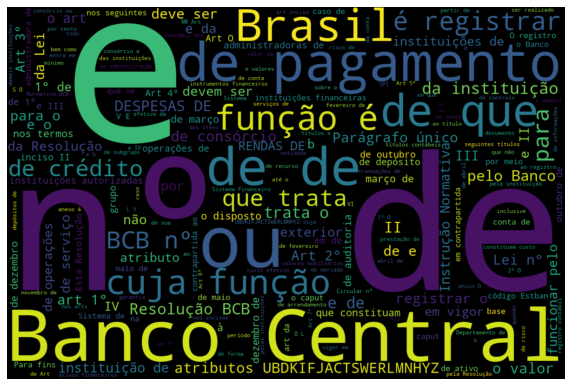

In [13]:
#Nuvem de palavras normas depois shuffle
nuvem_palavras_apos_shuffle = gera_nuvem_palavras(df.Texto)
desenha_palavras(nuvem_palavras_apos_shuffle)

total de palavras 736755


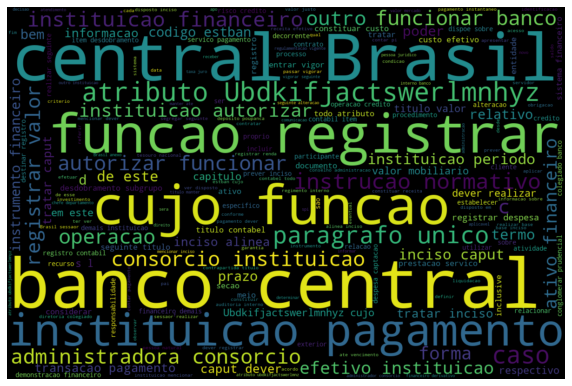

In [14]:
#Nuvem de palavras normas depois tratamento
nuvem_palavras_apos_shuffle_tratadas = gera_nuvem_palavras(df.texto_limpo)
desenha_palavras(nuvem_palavras_apos_shuffle_tratadas)

In [15]:
tokenizador = tokenize.WhitespaceTokenizer()
def gera_frequencia(tokenizador, textos):
  texto_tokenizado = tokenizador.tokenize(' '.join(textos))
  frequencia = nltk.FreqDist(texto_tokenizado)
  df_frequencia = pd.DataFrame({"Palavra": list(frequencia.keys()),
                                "Frequencia": list(frequencia.values())})
  df_frequencia15 = df_frequencia.nlargest(columns = "Frequencia", n = 20)
  print(df_frequencia15)
  return df_frequencia15

In [16]:
df_frequencia = gera_frequencia(tokenizador, df.texto_limpo)


         Palavra  Frequencia
13   instituicao        1586
52      atributo        1063
299        valor         969
86     pagamento         955
105        dever         936
16       central         916
20    financeiro         900
17        Brasil         853
24         banco         831
33        inciso         689
548    registrar         687
563       titulo         684
575       funcao         631
574         cujo         624
56      operacao         574
8          ativo         537
112      credito         512
204       tratar         509
113        outro         493
856      despesa         436


In [17]:
df_frequencia_at = gera_frequencia(tokenizador, df.Texto)


       Palavra  Frequencia
15          de       13243
45           e        4383
24          do        4284
10           a        3625
114          -        3075
63           o        2444
59          da        2429
57          no        2322
80         com        2089
160         em        2047
19         que        1804
216         ou        1671
40        para        1244
5           DE        1243
101       Art.        1107
21          as        1082
447        dos        1048
122  atributos        1047
199         os         984
348         ao         974


### TF-IDF e MODELOS

In [18]:
X_train, X_val, y_train, y_val = train_test_split(df["texto_limpo"],
                                                  df["CLASSE"],
                                                  test_size=0.2,
                                                  shuffle=True)

In [19]:
tfidf_vectorizer = TfidfVectorizer(use_idf=True)
X_train_vectors_tfidf = tfidf_vectorizer.fit_transform(X_train)

In [20]:
X_val_vectors_tfidf = tfidf_vectorizer.transform(X_val)

              precision    recall  f1-score   support

           0       0.91      0.71      0.80        14
           1       0.64      0.88      0.74         8

    accuracy                           0.77        22
   macro avg       0.77      0.79      0.77        22
weighted avg       0.81      0.77      0.78        22

Confusion Matrix: 
 [[10  4]
 [ 1  7]]
AUC: 0.9598214285714286


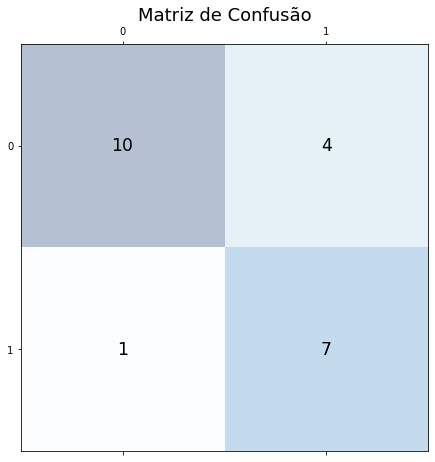

In [21]:
#FITTING o modelo de classificação usando Random Forest(tf-idf)
rf_tfidf = RandomForestClassifier(n_estimators=50)
rf_tfidf.fit(X_train_vectors_tfidf, y_train)  #modelo

#Prever o valor y para o conjunto de dados de teste
y_predict = rf_tfidf.predict(X_val_vectors_tfidf)
y_prob = rf_tfidf.predict_proba(X_val_vectors_tfidf)[:,1]

#print(classification_report(y_val,y_predict))
#print('Confusion Matrix: \n',confusion_matrix(y_val, y_predict))
 
fpr, tpr, thresholds = roc_curve(y_val, y_prob)
roc_auc = auc(fpr, tpr)
print('AUC:', roc_auc)  

conf_matrix = confusion_matrix(y_val, y_predict)

fig, ax = plt.subplots(figsize=(7.5, 7.5))
ax.matshow(conf_matrix, cmap=plt.cm.Blues, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
 
plt.title('Matriz de Confusão', fontsize=18)
plt.show()

              precision    recall  f1-score   support

           0       1.00      0.64      0.78        14
           1       0.62      1.00      0.76         8

    accuracy                           0.77        22
   macro avg       0.81      0.82      0.77        22
weighted avg       0.86      0.77      0.78        22

Confusion Matrix: 
 [[9 5]
 [0 8]]
AUC: 0.9642857142857143


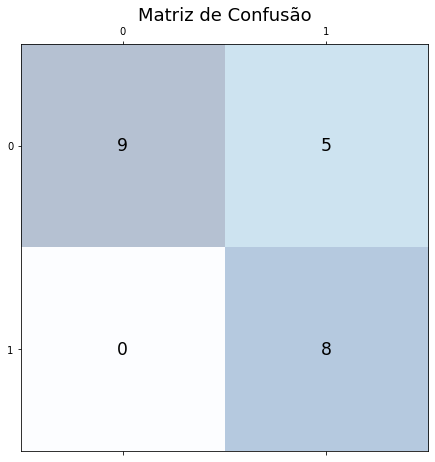

In [22]:
#FITTING o modelo de classificação usando Regressão Logística(tf-idf)
lr_tfidf=LogisticRegression(solver = 'lbfgs', multi_class='auto')
lr_tfidf.fit(X_train_vectors_tfidf, y_train)  #modelo

#Prever o valor y para o conjunto de dados de teste
y_predict = lr_tfidf.predict(X_val_vectors_tfidf)
y_prob = lr_tfidf.predict_proba(X_val_vectors_tfidf)[:,1]
 

print(classification_report(y_val,y_predict))
print('Confusion Matrix: \n',confusion_matrix(y_val, y_predict))
 
fpr, tpr, thresholds = roc_curve(y_val, y_prob)
roc_auc = auc(fpr, tpr)
print('AUC:', roc_auc)  

conf_matrix = confusion_matrix(y_val, y_predict)

fig, ax = plt.subplots(figsize=(7.5, 7.5))
ax.matshow(conf_matrix, cmap=plt.cm.Blues, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
 
plt.title('Matriz de Confusão', fontsize=18)
plt.show()

              precision    recall  f1-score   support

           0       1.00      0.79      0.88        14
           1       0.73      1.00      0.84         8

    accuracy                           0.86        22
   macro avg       0.86      0.89      0.86        22
weighted avg       0.90      0.86      0.87        22

Confusion Matrix: 
 [[11  3]
 [ 0  8]]
AUC: 0.9553571428571429


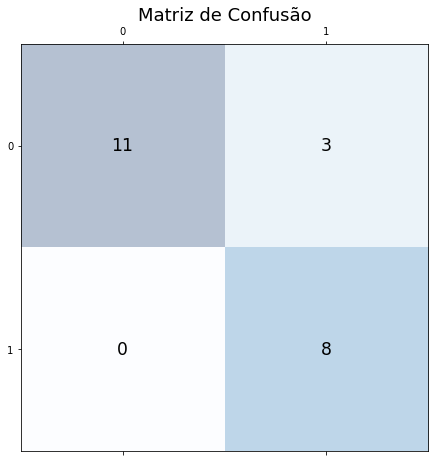

In [23]:
#FITTING o modelo de classificação usando Naive Bayes(tf-idf)
nb_tfidf = MultinomialNB()
nb_tfidf.fit(X_train_vectors_tfidf, y_train)  #modelo

#Prever o valor y para o conjunto de dados de teste
y_predict = nb_tfidf.predict(X_val_vectors_tfidf)
y_prob = nb_tfidf.predict_proba(X_val_vectors_tfidf)[:,1]
 

print(classification_report(y_val,y_predict))
print('Confusion Matrix: \n',confusion_matrix(y_val, y_predict))
 
fpr, tpr, thresholds = roc_curve(y_val, y_prob)
roc_auc = auc(fpr, tpr)
print('AUC:', roc_auc)  

conf_matrix = confusion_matrix(y_val, y_predict)

fig, ax = plt.subplots(figsize=(7.5, 7.5))
ax.matshow(conf_matrix, cmap=plt.cm.Blues, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
 
plt.title('Matriz de Confusão', fontsize=18)
plt.show()

              precision    recall  f1-score   support

           0       0.73      0.57      0.64        14
           1       0.45      0.62      0.53         8

    accuracy                           0.59        22
   macro avg       0.59      0.60      0.58        22
weighted avg       0.63      0.59      0.60        22

Confusion Matrix: 
 [[8 6]
 [3 5]]
AUC: 0.5982142857142857


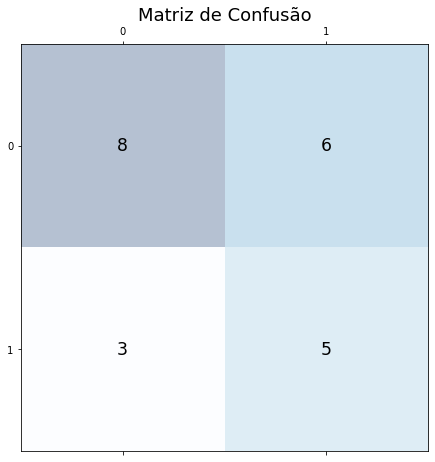

In [24]:
#FITTING o modelo de classificação usando Árvore de Decisão(tf-idf)
dtre_tfidf = DecisionTreeClassifier(max_depth=5)
dtre_tfidf.fit(X_train_vectors_tfidf, y_train)  #modelo

#Prever o valor y para o conjunto de dados de teste
y_predict = dtre_tfidf.predict(X_val_vectors_tfidf)
y_prob = dtre_tfidf.predict_proba(X_val_vectors_tfidf)[:,1]
 

print(classification_report(y_val,y_predict))
print('Confusion Matrix: \n',confusion_matrix(y_val, y_predict))
 
fpr, tpr, thresholds = roc_curve(y_val, y_prob)
roc_auc = auc(fpr, tpr)
print('AUC:', roc_auc)  

conf_matrix = confusion_matrix(y_val, y_predict)

fig, ax = plt.subplots(figsize=(7.5, 7.5))
ax.matshow(conf_matrix, cmap=plt.cm.Blues, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
 
plt.title('Matriz de Confusão', fontsize=18)
plt.show()

              precision    recall  f1-score   support

           0       0.81      0.93      0.87        14
           1       0.83      0.62      0.71         8

    accuracy                           0.82        22
   macro avg       0.82      0.78      0.79        22
weighted avg       0.82      0.82      0.81        22

Confusion Matrix: 
 [[13  1]
 [ 3  5]]
AUC: 0.8616071428571428


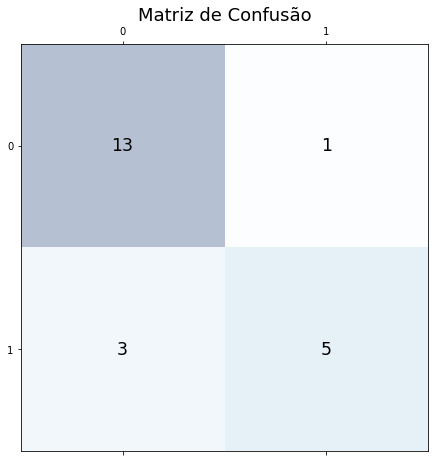

In [25]:
#FITTING o modelo de classificação usando KNN ( KNeighborsClassifier )
kn_tfidf = KNeighborsClassifier(n_neighbors=5)
kn_tfidf.fit(X_train_vectors_tfidf, y_train)  #modelo

#Prever o valor y para o conjunto de dados de teste
y_predict = kn_tfidf.predict(X_val_vectors_tfidf)
y_prob = kn_tfidf.predict_proba(X_val_vectors_tfidf)[:,1]
 

print(classification_report(y_val,y_predict))
print('Confusion Matrix: \n',confusion_matrix(y_val, y_predict))
 
fpr, tpr, thresholds = roc_curve(y_val, y_prob)
roc_auc = auc(fpr, tpr)
print('AUC:', roc_auc)  

conf_matrix = confusion_matrix(y_val, y_predict)

fig, ax = plt.subplots(figsize=(7.5, 7.5))
ax.matshow(conf_matrix, cmap=plt.cm.Blues, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
 
plt.title('Matriz de Confusão', fontsize=18)
plt.show()

### Aplicando os algoritmos

In [26]:
#Testando modelo com Regressão Logística
df_test = pd.read_excel('Base normas teste.xlsx')
df_test['texto_limpo'] = df_test['Texto'].apply(lambda x: finalprocessamento(x)) #pre-processamento
X_test=df_test['texto_limpo'] 
X_vector=tfidf_vectorizer.transform(X_test) #convertendo X_test para vetor
y_predict = lr_tfidf.predict(X_vector)      #usando o modelo treinado no X_vector
y_prob = lr_tfidf.predict_proba(X_vector)
df_test['target']= y_predict
df_test[['Norma', 'Texto', 'texto_limpo','CLASSE','target']]



,Norma,Texto,texto_limpo,CLASSE,target
0,274,"RESOLUÇÃO BCB Nº 274, DE 13 DE DEZEMBRO DE 202...",alter consolir norma sobre rito processo admin...,0,1
1,282,"RESOLUÇÃO BCB Nº 282, DE 31 DE DEZEMBRO DE 202...",alter circular dispoe sobre politica procedime...,0,1
2,296,"RESOLUÇÃO BCB Nº 296, DE 23 DE FEVEREIRO DE 20...",alter disciplina constituicao funcionamento in...,0,0
3,309,"RESOLUÇÃO BCB Nº 309, DE 28 DE MARÇO DE 2023\n...",estabelecer procedimento contabel sobre defini...,0,0
4,310,"RESOLUÇÃO BCB Nº 310, DE 12 DE ABRIL DE 2023\n...",alter consolida criterio geral elaboracao divu...,0,0
5,311,"RESOLUÇÃO BCB Nº 311, DE 12 DE ABRIL DE 2023\n...",alterar dispoe sobre criterio geral elaboracao...,0,0
6,266,"RESOLUÇÃO BCB Nº 266, DE 25 DE NOVEMBRO DE 202...",alter circular estabelecer procedimento calcul...,0,1
7,264,"RESOLUÇÃO BCB Nº 264, DE 25 DE NOVEMBRO DE 202...",dispoe sobre registro recebivel decorrente tra...,0,1
8,317,"RESOLUÇÃO BCB Nº 317, DE 27 DE ABRIL DE 2023\n...",fixo prazo maximos decisao administrativo pedi...,0,1
9,318,"RESOLUÇÃO BCB Nº 318, DE 10 DE MAIO DE 2023\n\...",alterar dispoe sobre prestacao servico auditor...,0,0


In [27]:
#Testando modelo com Naive-Bayes
df_test = pd.read_excel('Base normas teste.xlsx')
df_test['texto_limpo'] = df_test['Texto'].apply(lambda x: finalprocessamento(x)) #pre-processamento
X_test=df_test['texto_limpo'] 
X_vector=tfidf_vectorizer.transform(X_test) #convertendo X_test para vetor
y_predict = nb_tfidf.predict(X_vector)      #usando o modelo treinado no X_vector
y_prob = lr_tfidf.predict_proba(X_vector)[:,1]
df_test['target']= y_predict
df_test[['Norma', 'Texto', 'texto_limpo','CLASSE','target']]

,Norma,Texto,texto_limpo,CLASSE,target
0,274,"RESOLUÇÃO BCB Nº 274, DE 13 DE DEZEMBRO DE 202...",alter consolir norma sobre rito processo admin...,0,0
1,282,"RESOLUÇÃO BCB Nº 282, DE 31 DE DEZEMBRO DE 202...",alter circular dispoe sobre politica procedime...,0,1
2,296,"RESOLUÇÃO BCB Nº 296, DE 23 DE FEVEREIRO DE 20...",alter disciplina constituicao funcionamento in...,0,0
3,309,"RESOLUÇÃO BCB Nº 309, DE 28 DE MARÇO DE 2023\n...",estabelecer procedimento contabel sobre defini...,0,0
4,310,"RESOLUÇÃO BCB Nº 310, DE 12 DE ABRIL DE 2023\n...",alter consolida criterio geral elaboracao divu...,0,0
5,311,"RESOLUÇÃO BCB Nº 311, DE 12 DE ABRIL DE 2023\n...",alterar dispoe sobre criterio geral elaboracao...,0,0
6,266,"RESOLUÇÃO BCB Nº 266, DE 25 DE NOVEMBRO DE 202...",alter circular estabelecer procedimento calcul...,0,1
7,264,"RESOLUÇÃO BCB Nº 264, DE 25 DE NOVEMBRO DE 202...",dispoe sobre registro recebivel decorrente tra...,0,1
8,317,"RESOLUÇÃO BCB Nº 317, DE 27 DE ABRIL DE 2023\n...",fixo prazo maximos decisao administrativo pedi...,0,0
9,318,"RESOLUÇÃO BCB Nº 318, DE 10 DE MAIO DE 2023\n\...",alterar dispoe sobre prestacao servico auditor...,0,0


In [28]:
#Testando modelo com Random Forest
df_test = pd.read_excel('Base normas teste.xlsx')
df_test['texto_limpo'] = df_test['Texto'].apply(lambda x: finalprocessamento(x)) #pre-processamento
X_test=df_test['texto_limpo'] 
X_vector=tfidf_vectorizer.transform(X_test) #convertendo X_test para vetor
y_predict = rf_tfidf.predict(X_vector)      #usando o modelo treinado no X_vector
y_prob = rf_tfidf.predict_proba(X_vector)[:,1]
df_test['target']= y_predict
df_test[['Norma', 'Texto', 'texto_limpo','CLASSE','target']]

,Norma,Texto,texto_limpo,CLASSE,target
0,274,"RESOLUÇÃO BCB Nº 274, DE 13 DE DEZEMBRO DE 202...",alter consolir norma sobre rito processo admin...,0,1
1,282,"RESOLUÇÃO BCB Nº 282, DE 31 DE DEZEMBRO DE 202...",alter circular dispoe sobre politica procedime...,0,0
2,296,"RESOLUÇÃO BCB Nº 296, DE 23 DE FEVEREIRO DE 20...",alter disciplina constituicao funcionamento in...,0,0
3,309,"RESOLUÇÃO BCB Nº 309, DE 28 DE MARÇO DE 2023\n...",estabelecer procedimento contabel sobre defini...,0,0
4,310,"RESOLUÇÃO BCB Nº 310, DE 12 DE ABRIL DE 2023\n...",alter consolida criterio geral elaboracao divu...,0,0
5,311,"RESOLUÇÃO BCB Nº 311, DE 12 DE ABRIL DE 2023\n...",alterar dispoe sobre criterio geral elaboracao...,0,0
6,266,"RESOLUÇÃO BCB Nº 266, DE 25 DE NOVEMBRO DE 202...",alter circular estabelecer procedimento calcul...,0,1
7,264,"RESOLUÇÃO BCB Nº 264, DE 25 DE NOVEMBRO DE 202...",dispoe sobre registro recebivel decorrente tra...,0,1
8,317,"RESOLUÇÃO BCB Nº 317, DE 27 DE ABRIL DE 2023\n...",fixo prazo maximos decisao administrativo pedi...,0,1
9,318,"RESOLUÇÃO BCB Nº 318, DE 10 DE MAIO DE 2023\n\...",alterar dispoe sobre prestacao servico auditor...,0,0


In [29]:
#Testando modelo com árvore de decisão
df_test = pd.read_excel('Base normas teste.xlsx')
df_test['texto_limpo'] = df_test['Texto'].apply(lambda x: finalprocessamento(x)) #pre-processamento
X_test=df_test['texto_limpo'] 
X_vector=tfidf_vectorizer.transform(X_test) #convertendo X_test para vetor
y_predict = dtre_tfidf.predict(X_vector)      #usando o modelo treinado no X_vector
y_prob = dtre_tfidf.predict_proba(X_vector)
df_test['target']= y_predict
df_test[['Norma', 'Texto', 'texto_limpo','CLASSE','target']]


,Norma,Texto,texto_limpo,CLASSE,target
0,274,"RESOLUÇÃO BCB Nº 274, DE 13 DE DEZEMBRO DE 202...",alter consolir norma sobre rito processo admin...,0,1
1,282,"RESOLUÇÃO BCB Nº 282, DE 31 DE DEZEMBRO DE 202...",alter circular dispoe sobre politica procedime...,0,0
2,296,"RESOLUÇÃO BCB Nº 296, DE 23 DE FEVEREIRO DE 20...",alter disciplina constituicao funcionamento in...,0,0
3,309,"RESOLUÇÃO BCB Nº 309, DE 28 DE MARÇO DE 2023\n...",estabelecer procedimento contabel sobre defini...,0,0
4,310,"RESOLUÇÃO BCB Nº 310, DE 12 DE ABRIL DE 2023\n...",alter consolida criterio geral elaboracao divu...,0,0
5,311,"RESOLUÇÃO BCB Nº 311, DE 12 DE ABRIL DE 2023\n...",alterar dispoe sobre criterio geral elaboracao...,0,0
6,266,"RESOLUÇÃO BCB Nº 266, DE 25 DE NOVEMBRO DE 202...",alter circular estabelecer procedimento calcul...,0,0
7,264,"RESOLUÇÃO BCB Nº 264, DE 25 DE NOVEMBRO DE 202...",dispoe sobre registro recebivel decorrente tra...,0,1
8,317,"RESOLUÇÃO BCB Nº 317, DE 27 DE ABRIL DE 2023\n...",fixo prazo maximos decisao administrativo pedi...,0,0
9,318,"RESOLUÇÃO BCB Nº 318, DE 10 DE MAIO DE 2023\n\...",alterar dispoe sobre prestacao servico auditor...,0,0


In [30]:
#Testando modelo com KN
df_test = pd.read_excel('Base normas teste.xlsx')
df_test['texto_limpo'] = df_test['Texto'].apply(lambda x: finalprocessamento(x)) #pre-processamento
X_test=df_test['texto_limpo'] 
X_vector=tfidf_vectorizer.transform(X_test) #convertendo X_test para vetor
y_predict = kn_tfidf.predict(X_vector)      #usando o modelo treinado no X_vector
y_prob = kn_tfidf.predict_proba(X_vector)
df_test['target']= y_predict
df_test[['Norma', 'Texto', 'texto_limpo','CLASSE','target']]


,Norma,Texto,texto_limpo,CLASSE,target
0,274,"RESOLUÇÃO BCB Nº 274, DE 13 DE DEZEMBRO DE 202...",alter consolir norma sobre rito processo admin...,0,0
1,282,"RESOLUÇÃO BCB Nº 282, DE 31 DE DEZEMBRO DE 202...",alter circular dispoe sobre politica procedime...,0,0
2,296,"RESOLUÇÃO BCB Nº 296, DE 23 DE FEVEREIRO DE 20...",alter disciplina constituicao funcionamento in...,0,0
3,309,"RESOLUÇÃO BCB Nº 309, DE 28 DE MARÇO DE 2023\n...",estabelecer procedimento contabel sobre defini...,0,1
4,310,"RESOLUÇÃO BCB Nº 310, DE 12 DE ABRIL DE 2023\n...",alter consolida criterio geral elaboracao divu...,0,0
5,311,"RESOLUÇÃO BCB Nº 311, DE 12 DE ABRIL DE 2023\n...",alterar dispoe sobre criterio geral elaboracao...,0,0
6,266,"RESOLUÇÃO BCB Nº 266, DE 25 DE NOVEMBRO DE 202...",alter circular estabelecer procedimento calcul...,0,1
7,264,"RESOLUÇÃO BCB Nº 264, DE 25 DE NOVEMBRO DE 202...",dispoe sobre registro recebivel decorrente tra...,0,0
8,317,"RESOLUÇÃO BCB Nº 317, DE 27 DE ABRIL DE 2023\n...",fixo prazo maximos decisao administrativo pedi...,0,0
9,318,"RESOLUÇÃO BCB Nº 318, DE 10 DE MAIO DE 2023\n\...",alterar dispoe sobre prestacao servico auditor...,0,0
